In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm, LinearSegmentedColormap, Normalize

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import os

In [22]:
import visualizer

In [23]:
df = pd.read_csv("QF_S_PARSED.csv")

In [24]:
df["task-clock:u"] = df["task-clock:u"].astype(float)
reduced_df = df[["solver", "problem", "status", "sanity_sat", "task-clock:u", "elapsed"]].copy()

In [25]:
pivot_df = reduced_df.pivot(index='problem', columns='solver', values='task-clock:u')

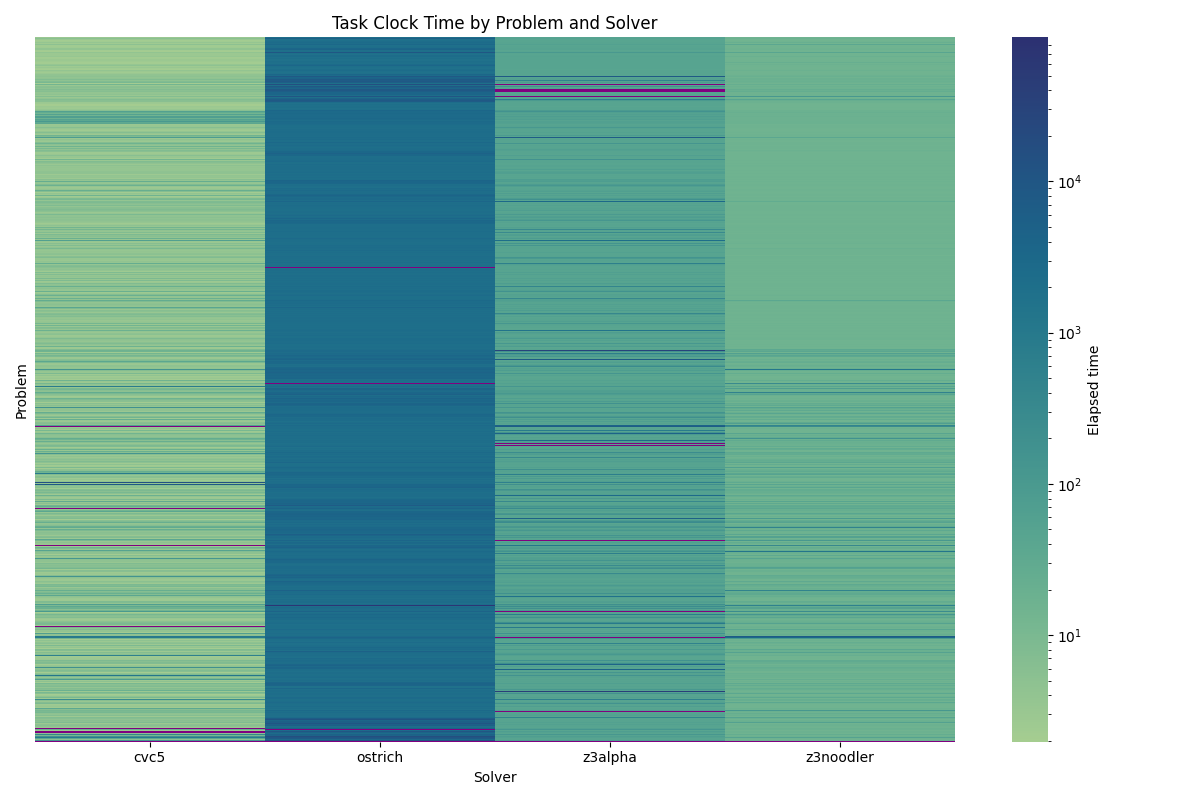

In [12]:
%matplotlib widget
visualize

In [13]:
# Modify 'folder' column using .loc
reduced_df.loc[:, 'folder'] = reduced_df['problem'].apply(lambda x: os.path.dirname(x))

# Apply the second transformation on 'folder' using .loc
reduced_df.loc[:, 'folder'] = reduced_df['problem'].apply(
    lambda x: '/'.join(x.split(os.sep)[4:][:-1])  # Remove the first three directories
)

# Modify 'problem' column using .loc
reduced_df.loc[:, 'problem'] = reduced_df['problem'].apply(
    lambda x: x.split("/")[-1]
)

In [14]:
pivot_df = reduced_df.pivot(index=["folder", 'problem'], columns='solver', values='task-clock:u')

In [15]:
folders = pivot_df.index.get_level_values('folder')
y_labels = np.where(folders.duplicated(keep='first'), "", folders)

In [16]:
new_index = []
new_pivot_df = []

last_folder = None
empty_rows_count = 100  # Number of empty rows to add between folders
for i, (folder, row) in enumerate(pivot_df.iterrows()):
    # Add multiple blank rows between different folders
    if folder[0] != last_folder:
        for _ in range(empty_rows_count):  # Add 5 blank rows
            new_index.append(('', ''))  # Blank row
            new_pivot_df.append([np.nan] * len(pivot_df.columns))  # NaN values for blank row
    new_index.append(folder)
    new_pivot_df.append(row)
    last_folder = folder[0]

In [17]:
pivot_df_with_blanks = pd.DataFrame(new_pivot_df, index=pd.MultiIndex.from_tuples(new_index, names=pivot_df.index.names), columns=pivot_df.columns)

In [18]:
folders = pivot_df.index.get_level_values('folder').unique()

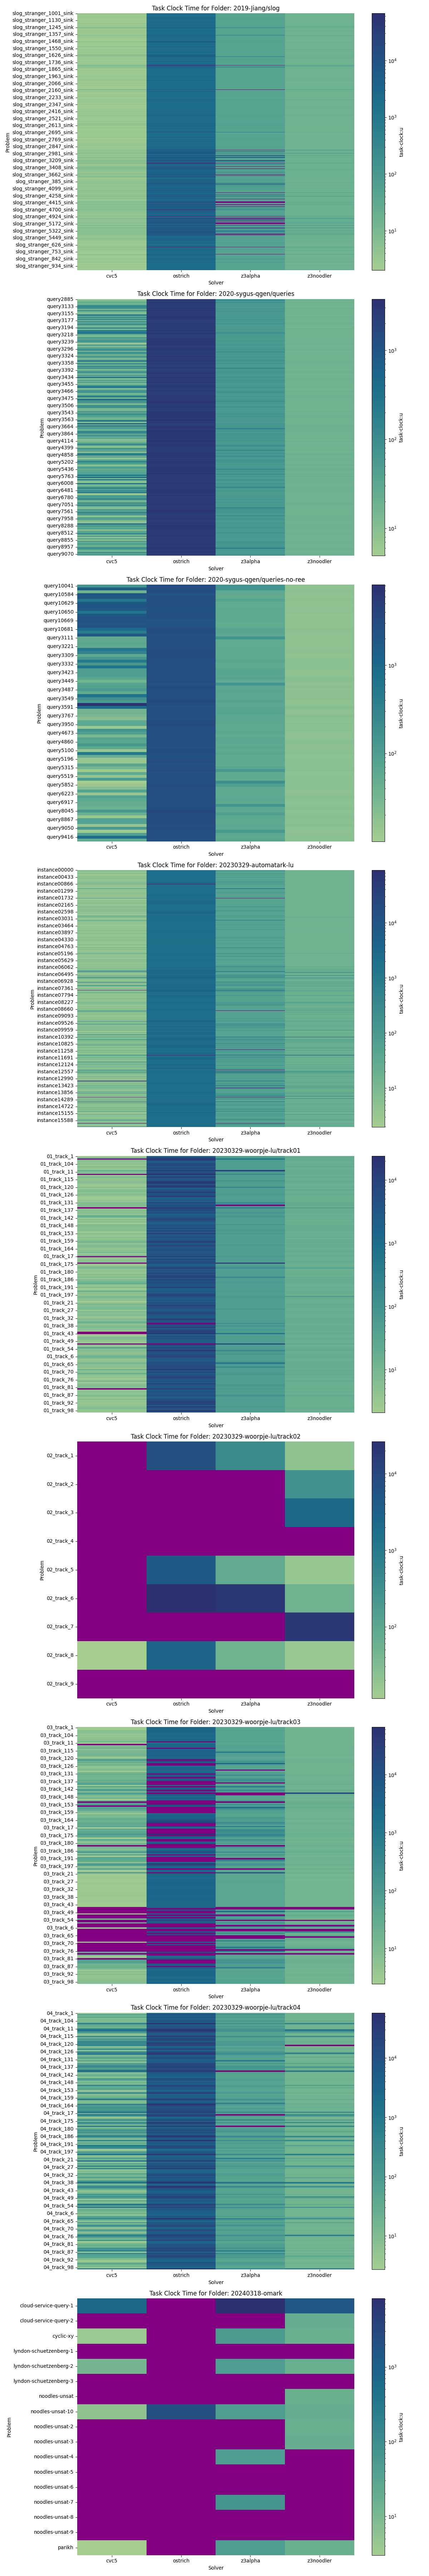

In [19]:
%matplotlib widget

# Define the bad color for NaN values
bad_color = 'purple'  # You can change this to any color you'd like

# Create a subplot grid with enough rows for each folder
n_folders = len(folders)
fig, axes = plt.subplots(n_folders, 1, figsize=(12, 8 * n_folders))

# If there's only one folder, `axes` will not be an array, so we need to ensure it's iterable
if n_folders == 1:
    axes = [axes]

cmap = sns.color_palette("crest", as_cmap=True) # You can use any colormap you like
cmap.set_bad(bad_color)  # Set the "bad" color for NaN values

# Loop through each folder and plot its respective data in the corresponding subplot
for i, folder in enumerate(folders):
    # Filter the pivot table for the current folder
    folder_data = pivot_df.xs(folder, level='folder')

    # Create a mask for NaN values (or any other condition)
    mask = folder_data.isna()  # Mask NaN values

    # Plot the heatmap for the current folder
    sns.heatmap(
        folder_data,
        ax=axes[i],
        fmt=".2f",
        cbar_kws={'label': 'task-clock:u'},
        norm=LogNorm(),
        mask=mask,  # Apply the mask to NaN values
        cmap=cmap,  # Use the custom colormap with bad color
        cbar=False,  # Disable colorbar to avoid redundancy if it's not needed
    )

    # Set the title and labels for each subplot
    axes[i].set_title(f'Task Clock Time for Folder: {folder}')
    axes[i].set_xlabel('Solver')
    axes[i].set_ylabel('Problem')

    # Adding the colorbar to the first plot
    plt.colorbar(axes[i].get_children()[0], ax=axes[i], label="task-clock:u")

# Adjust layout
plt.tight_layout()

---

## Generall Infos

In [20]:
ostrich = df[df["solver"] == "ostrich"]
cvc = df[df["solver"] == "cvc5"]
noodler = df[df["solver"] == "z3noodler"]
alpha = df[df["solver"] == "z3alpha"]

In [21]:
success = df[df["status"] == "Success"]
success[~success["sanity_sat"].isin(["sat", "unsat"])]

,Unnamed: 0,problem,solver,status,sanity_sat,task-clock:u,context-switches:u,cpu-migrations:u,page-faults:u,cycles:u,...,branches:u,branch-misses:u,slots:u,topdown-retiring:u,topdown-bad-spec:u,topdown-fe-bound:u,topdown-be-bound:u,elapsed,user,sys
826,826,out/benchmarks/non-incremental/QF_S/20230329-a...,z3alpha,Success,Performance counter stats for '/software/pytho...,54875.91,0.0,0.0,353811.0,1.947803e+11,...,8.435888e+10,118371370.0,9.723373e+11,2.960952e+11,1.983260e+11,6.394942e+10,4.360905e+11,54.886672,54.173789,0.580751
26184,26184,out/benchmarks/non-incremental/QF_S/20230329-a...,z3alpha,Success,Performance counter stats for '/software/pytho...,31349.45,0.0,0.0,66256.0,1.119310e+11,...,3.195671e+10,709146486.0,5.593604e+11,1.199731e+11,2.039956e+11,1.036569e+11,1.678972e+11,31.360989,31.171394,0.078702
